In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

from spectral_cube import SpectralCube

from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize, PercentileInterval, AsinhStretch, ManualInterval)

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def make_wcs(xcent, ycent, ra, dec, pxscale, angle=90, naxis=2):
    """Makes a WCS using a reference pixel given by (x, y) at (ra, dec), 
    and a pixel scale of the image. The rotation is done wrt the reference pixel, so it's easiest to define
    central pixel as the reference one.
    By default, makes a north-aligned J2000 2-d WCS. Can convert this to a fits header using wcs.to_header(). 
    Reference: https://docs.astropy.org/en/stable/wcs/
    https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf
    
    INPUTS:
        xcent, ycent    = pixel coordinates of the ref. pixel (preferred: image center)
        ra, dec = physical coordinates of the ref. pixel
        pxscale = pixel scale of the image (in arcsec/px)
    OPTIONAL:
        angle = rotation angle in degrees; default: 90 (aligned with North)
        naxis = number of axes; default: 2 (set to 3 for spectral cube)
        ...not sure how spectral WCS work so work in progress
    RETURNS:
        wcs: astropy WCS object
    """
    
    # Create a new WCS object.  The number of axes must be set from the start
    w = WCS(naxis=naxis)
    
    # Set up the reference coordinates
    w.wcs.crpix = [xcent, ycent]   # Reference pixel corresponding to ra, dec from crval
    w.wcs.crval = [ra, dec]
    
    # Rotation matrix
    th      = angle*np.pi/180
    rot_mat = np.array([[-np.sin(th), np.cos(th)], [np.cos(th), np.sin(th)]])
    
    # PC matrix = Pixel Scale * Rotation matrix
    pxscale  = pxscale / 3600    # convert arcsec/px to deg/px
    w.wcs.pc = pxscale * rot_mat
    
    # Coordinate type: default
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    
    return w

In [4]:
def make_wcs_3d(xcent, ycent, crpix3, ra, dec, crval3, pxscale, cdelt3, naxis=3):
    """Makes a WCS using a reference pixel given by (x, y) at (ra, dec), 
    and a pixel scale of the image. The rotation is done wrt the reference pixel, so it's easiest to define
    central pixel as the reference one.
    By default, makes a north-aligned J2000 2-d WCS. Can convert this to a fits header using wcs.to_header(). 
    Reference: https://docs.astropy.org/en/stable/wcs/
    https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf
    
    INPUTS:
        xcent, ycent    = pixel coordinates of the ref. pixel (preferred: image center)
        ra, dec = physical coordinates of the ref. pixel
        pxscale = pixel scale of the image (in arcsec/px)
    OPTIONAL:
        angle = rotation angle in degrees; default: 90 (aligned with North)
        naxis = number of axes; default: 2 (set to 3 for spectral cube)
        ...not sure how spectral WCS work so work in progress
    RETURNS:
        wcs: astropy WCS object
    """
    
    # Create a new WCS object.  The number of axes must be set from the start
    w = WCS(naxis=naxis)
    
    # Set up the reference coordinates
    w.wcs.crpix = [xcent, ycent, crpix3]   # Reference pixel corresponding to ra, dec from crval
    w.wcs.crval = [ra, dec, crval3]
    
    
    # PC matrix = Pixel Scale * Rotation matrix
    pxscale  = pxscale / 3600    # convert arcsec/px to deg/px
    pc_matrix = np.array([np.array([pxscale, 0, 0]), np.array([0, pxscale, 0]), np.array([0, 0, cdelt3])])
    w.wcs.pc = pc_matrix
    
    # Coordinate type: default
    w.wcs.ctype = ["RA---TAN", "DEC--TAN", "WAVE"]
    
    return w

def move_wcs_pix_3d(dx, dy, wcs):
    """Given (dx, dy) in px, translate the image horizontally/vertically by changing the
    coordinate of the reference pixel"""
    
    # Figure out the change in the reference coordinates for given (dy, dx)
    
    d_crpix = np.array([dx, dy, 0])
    
    # Change the reference pixel's ra, dec 
    new_wcs       = wcs.deepcopy()
    new_crpix     = wcs.wcs.crpix + d_crpix
    new_wcs.wcs.crpix = new_crpix
    return new_wcs

In [5]:
def rotate_wcs(angle, wcs):
    """Rotates the WCS by an angle (given in degrees)""" 
    th          = angle*np.pi/180   # Convert to radians
    new_wcs     = wcs.deepcopy()    # Copy input WCS so that it's not overwritten
    
    # Multiply PCs by a rotation matrix
    rotation       = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]]) 
    new_wcs.wcs.pc = rotation.dot(wcs.wcs.pc)
    return new_wcs

def move_wcs(dx, dy, wcs):
    """Given (dx, dy) in px, translate the image horizontally/vertically by changing the
    coordinate of the reference pixel"""
    
    # Figure out the change in the reference coordinates for given (dy, dx)
    pc      = wcs.wcs.pc
    d_crval = pc.dot(np.array([dx, dy])) 
    
    # Change the reference pixel's ra, dec 
    new_wcs       = wcs.deepcopy()
    new_crval     = wcs.wcs.crval + d_crval
    new_wcs.wcs.crval = new_crval
    return new_wcs

def move_wcs_pix(dx, dy, wcs):
    """Given (dx, dy) in px, translate the image horizontally/vertically by changing the
    coordinate of the reference pixel"""
    
    # Figure out the change in the reference coordinates for given (dy, dx)
    
    d_crpix = np.array([dx, dy])
    
    # Change the reference pixel's ra, dec 
    new_wcs       = wcs.deepcopy()
    new_crpix     = wcs.wcs.crpix + d_crpix
    new_wcs.wcs.crpix = new_crpix
    return new_wcs

In [6]:
## load in raw NIFS data and first do some trimming

#raw_nifs = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/nov_reduction/dec6_run/TOTAL_mergedK_dec6.fits')
#raw_nifs = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/man_offset2/TOTAL_mergedK.fits')

#raw_cube = raw_nifs[1].data

##from CARTA inspection
#x bounds: 5, 73
#y bounds: 5, 64
#lam bounds: 80, 2025

#trim_cube = raw_cube[80:2025, 5:64, 5:73]
#trim_cube.shape


In [8]:
## load in NIFS data

nifs_orig = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_final_trim_wcs2.fits')
cube_orig = nifs_orig[1].data
nifs_header_orig = nifs_orig[1].header
nifs_wcs_orig = WCS(nifs_header_orig).celestial
nifs_wcs_orig_full = WCS(nifs_header_orig)
nifs_orig.close()

cube = cube_orig

#nifs_img_orig = np.nansum(cube_orig[350:600,:,:], axis=0)

#nifs_img_orig = nifs_img_orig/np.nanmax(nifs_img_orig)

#nifs = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_final_trim.fits')
#cube = trim_cube#nifs[1].data
nifs_wcs = nifs_wcs_orig#WCS(nifs_header).celestial
#the WCS from the 0th extension is bad - gives really weird results, clearly wrong

#raw_nifs.close()

#nifs_img = np.nansum(cube[125:1950,:,:], axis=0)
#nifs_img = np.nansum(cube[645:656,:,:], axis=0) #H2 line
nifs_img = np.nansum(cube[560:630,:,:], axis=0)

nifs_img = nifs_img/np.nanmax(nifs_img)

ra = "03 16 00.7739640240"
dec = "-02 25 37.827013584"

simbad_cent = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.degree))
simbad_nifs = nifs_wcs.all_world2pix(simbad_cent.ra.value, simbad_cent.dec.value, 0)

con_lvs = np.logspace(np.log10(0.5),np.log10(0.9995),3)


print(nifs_wcs)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 49.003394  -2.427118  
CRPIX : 66.999944  60.000178  
CD1_1 CD1_2  : 1.1944444444444e-05  0.0  
CD2_1 CD2_2  : 0.0  1.1944444444444e-05  
NAXIS : 79  68


In [9]:
### starting new NIFS wcs from scratch bc old one is weird (RA is increasing)

imgshape = nifs_img.shape
nifs_pxscale = ((1.1944444444444e-05*u.degree).to(u.arcsecond)).value
cdelt3 = nifs_header_orig['CDELT3']
crval3 = nifs_header_orig['CRVAL3']
crpix3 = nifs_header_orig['CRPIX3']

new_nifs = make_wcs_3d(imgshape[0]/2, imgshape[1]/2, crpix3, simbad_cent.ra.value, 
                    simbad_cent.dec.value, crval3, nifs_pxscale, cdelt3, naxis=3)
print(new_nifs)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 49.00322485009999  -2.42717417044  1.9969009765625e-06  
CRPIX : 34.0  39.5  -57.0  
PC1_1 PC1_2 PC1_3  : 1.1944444444444e-05  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.1944444444444e-05  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  2.1325941085815e-10  
CDELT : 1.0  1.0  1.0  
NAXIS : 0  0


In [10]:
## load in CTIO data

ctio_fl = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/CTIO_data/ngc1266_R_dr4.fits')

ctio_img = ctio_fl[0].data
ctio_header = ctio_fl[0].header
ctio_fl.close()

ctio_wcs = WCS(ctio_header)



position = SkyCoord(ra, dec, unit=(u.hourangle, u.degree), frame='icrs')
size = (100, 100)  # pixels
ctio_ct = Cutout2D(ctio_img, position, size, wcs=ctio_wcs)

norm_ctio = ImageNormalize(ctio_ct.data, interval=PercentileInterval(99.),
                      stretch=SqrtStretch())


In [11]:
## load in HST data

hst_fl = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/HST/ngc1266_f160w_0p14_drz.fits')

hst_img = hst_fl[1].data
hst_header = hst_fl[1].header
hst_fl.close()

hst_wcs = WCS(hst_header)

norm_hst = ImageNormalize(hst_img, interval=PercentileInterval(99.993),
                      stretch=SqrtStretch())
norm_hst_deep = ImageNormalize(hst_img, interval=PercentileInterval(99.9995),
                      stretch=SqrtStretch())




In [12]:
##loading in CO data

z = 0.007214

co_path = '/Users/jotter/highres_PSBs/ngc1266_data/ngc1266_co.fits'
co_cube = SpectralCube.read(co_path)

co_freq = 115.3 * u.GHz
co_freq_obs = co_freq / (1+z)
co_cube_kms = co_cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=co_freq_obs)
co_slab = co_cube_kms.spectral_slab(-600*u.km/u.s, 600*u.km/u.s)

co_wcs = co_cube_kms.wcs.celestial

co_mom0 = co_slab.moment(0)

#co_beam = Beam.from_fits_header(co_cube.header)

In [13]:
##loading in VLA data
vla_fl = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/VLA/NGC1266_Cband_Aconfig_subim.fits')

vla_data = vla_fl[0].data.squeeze()
vla_header = vla_fl[0].header

vla_fl.close()

vla_wcs = WCS(vla_header).celestial

vla_levels = np.array([1,3,6,15,50,136, 165]) * 0.07*1e-3

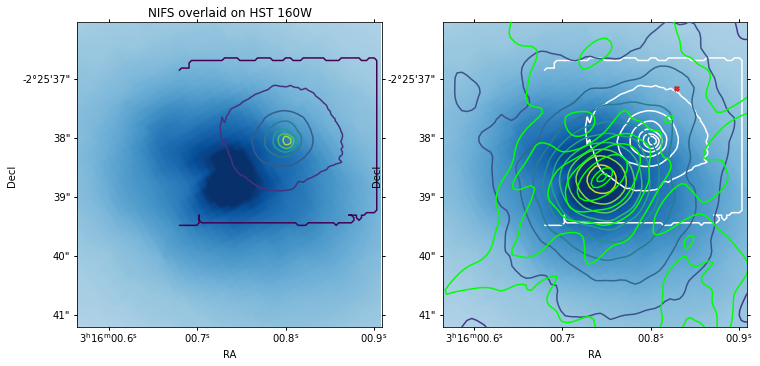

In [38]:
#first try


fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(121, projection=new_nifs.celestial)
ax0.imshow(hst_img, transform=ax0.get_transform(hst_wcs), cmap="Blues", norm=norm_hst)
ax0.contour(nifs_img)#,con_lvs*np.max(nifs_img),colors='k',transform=ax0.get_transform(nifs_wcs),alpha=0.6) 

#xlim = (-100,100)
ax0.set_xlim(-40,80)
ax0.set_ylim(-40,80)
ax0.set_xlabel('RA')
ax0.set_ylabel('Decl')

ax0.set_title('NIFS overlaid on HST 160W')

ax1 = fig.add_subplot(122, projection=new_nifs.celestial)
ax1.imshow(hst_img, transform=ax1.get_transform(hst_wcs), cmap="Blues", origin="lower",norm=norm_hst)
ax1.contour(nifs_img,colors='white',transform=ax1.get_transform(new_nifs.celestial)) 
ax1.set_xlim(-40,80)
ax1.set_ylim(-40,80)
ax1.set_xlabel('RA')
ax1.set_ylabel('Decl')

ax1.contour(co_mom0, levels=10, transform=ax1.get_transform(co_wcs))
ax1.contour(vla_data, levels=vla_levels, transform=ax1.get_transform(vla_wcs), colors='lime')


ax1.plot(simbad_nifs[0], simbad_nifs[1], marker='X', markersize=5, color='tab:red')

In [35]:
#nifs_wcs_edit = rotate_wcs(25, nifs_wcs)
#nifs_wcs_edit = move_wcs_pix(47,20, nifs_wcs)
nifs_wcs_edit = move_wcs_pix_3d(20,14.5, new_nifs)

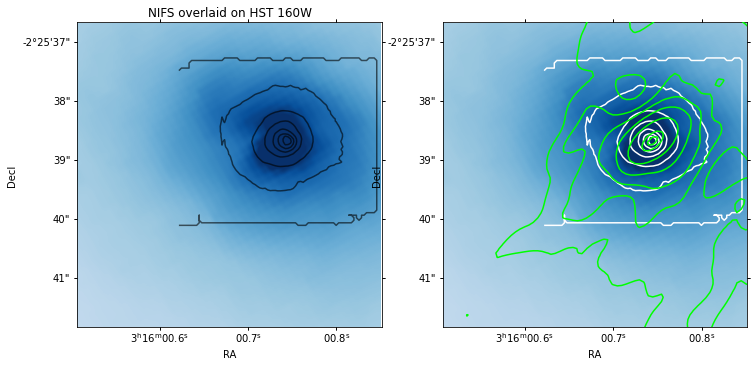

In [36]:
#second try
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(121, projection=nifs_wcs_edit.celestial)
ax0.imshow(hst_img, transform=ax0.get_transform(hst_wcs), cmap="Blues", origin="lower",norm=norm_hst)
ax0.contour(nifs_img,colors='k',transform=ax0.get_transform(nifs_wcs_edit.celestial),alpha=0.6) 

ax0.set_xlim(-40,80)
ax0.set_ylim(-40,80)
ax0.set_xlabel('RA')
ax0.set_ylabel('Decl')

ax0.set_title('NIFS overlaid on HST 160W')

ax1 = fig.add_subplot(122, projection=nifs_wcs_edit.celestial)
ax1.imshow(hst_img, transform=ax1.get_transform(hst_wcs), cmap="Blues", origin="lower",norm=norm_hst)
ax1.contour(nifs_img,colors='white',transform=ax1.get_transform(nifs_wcs_edit.celestial)) 
ax1.set_xlim(-40,80)
ax1.set_ylim(-40,80)
ax1.set_xlabel('RA')
ax1.set_ylabel('Decl')

#ax1.contour(co_mom0, levels=20, transform=ax1.get_transform(co_wcs))
ax1.contour(vla_data, levels=vla_levels, transform=ax1.get_transform(vla_wcs), colors='lime')


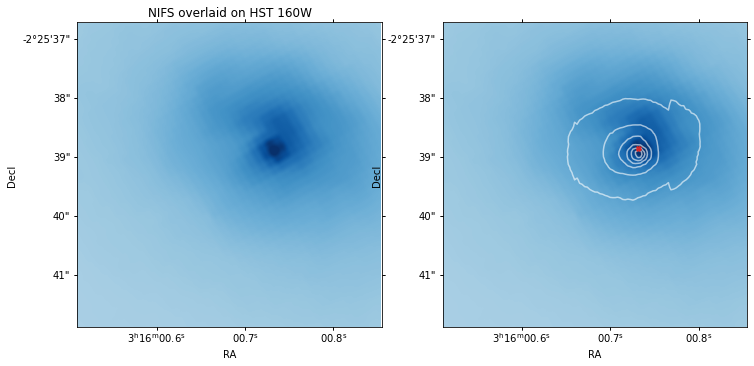

In [90]:
#second try
fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(121, projection=nifs_wcs_edit)
ax0.imshow(hst_img, transform=ax0.get_transform(hst_wcs), cmap="Blues", origin="lower",norm=norm_hst_deep)

ax0.set_xlim(-40,80)
ax0.set_ylim(-40,80)
ax0.set_xlabel('RA')
ax0.set_ylabel('Decl')

ax0.set_title('NIFS overlaid on HST 160W')

ax1 = fig.add_subplot(122, projection=nifs_wcs_edit)
ax1.imshow(hst_img, transform=ax1.get_transform(hst_wcs), cmap="Blues", origin="lower",norm=norm_hst_deep)
ax1.contour(nifs_img,colors='w',transform=ax1.get_transform(nifs_wcs_edit),alpha=0.6) 
ax1.set_xlim(-40,80)
ax1.set_ylim(-40,80)
ax1.set_xlabel('RA')
ax1.set_ylabel('Decl')

ra2 = "3:16:00.7311"
dec2 = "-2:25:38.844"

hst_cent = SkyCoord(ra=ra2, dec=dec2, unit=(u.hourangle, u.degree))
hst_nifs_edit = nifs_wcs_edit.all_world2pix(hst_cent.ra.value, hst_cent.dec.value, 0)
ax1.plot(hst_nifs_edit[0], hst_nifs_edit[1], marker='X', markersize=5, color='tab:red')

In [40]:
nifs_wcs_edit.wcs.crpix

array([ 54.,  54., -57.])

In [39]:
new_nifs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 49.00322485009999  -2.42717417044  1.9969009765625e-06  
CRPIX : 34.0  39.5  -57.0  
PC1_1 PC1_2 PC1_3  : 1.1944444444444e-05  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.1944444444444e-05  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  2.1325941085815e-10  
CDELT : 1.0  1.0  1.0  
NAXIS : 0  0

In [65]:
nifs_wcs_orig_full

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 49.003394  -2.427118  1.9969009765625e-06  
CRPIX : 66.999944  60.000178  -57.0  
CD1_1 CD1_2 CD1_3  : 1.1944444444444e-05  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  1.1944444444444e-05  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  2.1325941085815e-10  
NAXIS : 79  68  1960

In [42]:
#this is the good way of saving the updated wcs info
nifs = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_final_trim_wcs2.fits')

nifs[1].header['CRPIX1'] = nifs_wcs_edit.wcs.crpix[0]
nifs[1].header['CRPIX2'] = nifs_wcs_edit.wcs.crpix[1]

nifs.writeto('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_jun28_wcs.fits', overwrite=True)

nifs.close()

In [43]:
## this method of saving the wcs is fucking up the spectral axis - try another way

##DO NOT USE

## save updated WCS CRPIX

nifs = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_final_trim_wcs2.fits')
prev_cube = nifs[1].data
head = nifs[1].header
nifs[1].data = prev_cube
#crpix1 = nifs[1].header['CRPIX1'] + 52
#crpix2 = nifs[1].header['CRPIX2'] + 26

#nifs[1].header['CRPIX1'] = crpix1
#nifs[1].header['CRPIX2'] = crpix2

wcs_head = nifs_wcs_edit.to_header()
old_head = nifs_wcs_orig_full.to_header()
wcs_head['WCSAXES'] = 3
wcs_head['CRPIX3'] = old_head['CRPIX3']#-79
wcs_head['PC3_3'] = old_head['PC3_3']
wcs_head['CDELT3'] = old_head['CDELT3']
wcs_head['CUNIT3'] = old_head['CUNIT3']
wcs_head['CTYPE3'] = old_head['CTYPE3']
wcs_head['CRVAL3'] = old_head['CRVAL3']
#wcs_head
for card in wcs_head.keys():
    nifs[1].header[card] = wcs_head[card]
    nifs[0].header[card] = wcs_head[card]

nifs[1].header.remove('CD3_3')

new_wcs = WCS(wcs_head)

#nifs.writeto('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_jun28_wcs.fits', overwrite=True)

nifs.close()
#nifs[1].header
new_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 49.0032248501  -2.42717417044  1.9969009765625e-06  
CRPIX : 54.0  54.0  -57.0  
PC1_1 PC1_2 PC1_3  : 1.1944444444444e-05  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.1944444444444e-05  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  2.1325941085815e-10  
CDELT : 1.0  1.0  1.0  
NAXIS : 0  0

# doing this for Obs49 cube


I don't care about having an accurate wcs so just doing it rough

In [57]:
## first trim the cube to get rid of bad parts

nifs = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/man_offset2/20141110_obs49_merged.fits')
orig_cube = nifs[1].data
cube = orig_cube[60:,:,:]#[93:2020, 3:59, 4:59]

nifs.close()

cent = SkyCoord(ra='3:16:00.74568', dec='-2:25:38.738', unit=(u.hourangle, u.degree))
nifs_wcs = make_wcs(32, 33, cent.ra.degree, cent.dec.degree , 0.043, angle=90, naxis=2)

nifs2 = fits.open('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/man_offset2/20141110_obs49_merged.fits')

nifs2[1].data = cube

nifs2[1].header = nifs_header

'''nifs_good_head = nifs_good_wcs.to_header()
for key in nifs_good_head:#nifs_header:
    nifs2[1].header[key] = nifs_good_head[key]

del nifs2[1].header['PC1_1']
del nifs2[1].header['PC2_2']
del nifs2[1].header['PC3_3']
del nifs2[1].header['CDELT1']
del nifs2[1].header['CDELT2']
del nifs2[1].header['CDELT3']

nifs2[1].header['CD1_1'] = 1.1944444444444E-05 
nifs2[1].header['CD2_2'] = 1.1944444444444E-05 
nifs2[1].header['CD3_3'] = 2.1325941085815E-10
'''

nifs2.writeto('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/man_offset2/20141110_obs49_merged_wcs_trim.fits', overwrite=True)


In [52]:
WCS(nifs2[1].header)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 49.003394  -2.427118  1.9969009765625e-06  
CRPIX : 14.999944  34.000178  -57.0  
CD1_1 CD1_2 CD1_3  : 1.1944444444444e-05  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  1.1944444444444e-05  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  2.1325941085815e-10  
NAXIS : 69  66  2040

In [53]:
nifs2[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                   69 / Axis length                                    
NAXIS2  =                   66 / Axis length                                    
NAXIS3  =                 2040 / Axis length                                    
PCOUNT  =                    0 / No 'random' parameters                         
GCOUNT  =                    1 / Only one group                                 
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
OBJECT  = 'NGC1266 '           / Name of the object observed                    
DATE    = '2023-06-28T14:51:59' / Date FITS file was generated                  
IRAF-TLM= '2023-06-28T14:51:44' / Time of last modification                     
NFPAD   = '2023-06-15T19:15:

In [54]:
cube.shape

(2040, 66, 69)

In [56]:
cube.shape

(1960, 68, 79)